<a href="https://colab.research.google.com/github/sk48880/AV-WNS-Analytics-wizard-2019/blob/master/WNS_Analytics_Wizard_Click_through_rate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

The task is to predict click probability i.e. probability of user clicking the ad which is shown to them on the partner websites for the next 7 days on the basis of historical view log data, ad impression data and user data.

#### Evaluation Metric
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### Key points
- The E-commerce company sells multiple products on its platform
User behavior is recorded in the logs
- View log of users is for around 22 days (15th Oct 2018 - 5th Nov 2018)
- Train data has the impression logs for 29 days (15th Nov 2018 – 13th Dec 2018) along with the label which specifies whether the ad is clicked or not
- Test data have impression logs for 7 days (12th Dec 2018 – 18th Dec 2018) without the labels
- 12th and 13th Dec are overlap between train and test dataset. We can put a lookup to see if the user_id matches then, for those we can input the values
- The product description is collected from the Zbay website

## Load Libraries

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import datetime

import gc
import itertools

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Load Dataset

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.9MB/s 


In [3]:
link = 'https://drive.google.com/open?id=1tL9tqvUsClU7pCH8d-nvjfzmVZOdBuCh' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')  

link = 'https://drive.google.com/open?id=165F9lJJJYSPB4yGWyQjDMWCudQHSyTxB' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test.csv')  

link = 'https://drive.google.com/open?id=1cXIyr5cdNvc3u36qCjIhtNjTPjv4lDJc' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('sample_submission.csv')  

link = 'https://drive.google.com/open?id=1jym6T5H3-TLaz3m1XZ7tA_SIDNIok96d' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('item_data.csv')  

link = 'https://drive.google.com/open?id=1PfXH8UF3jqqAbO-s3LsHtZy1MsFHglyC' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('view_log.csv')  

1tL9tqvUsClU7pCH8d-nvjfzmVZOdBuCh
165F9lJJJYSPB4yGWyQjDMWCudQHSyTxB
1cXIyr5cdNvc3u36qCjIhtNjTPjv4lDJc
1jym6T5H3-TLaz3m1XZ7tA_SIDNIok96d
1PfXH8UF3jqqAbO-s3LsHtZy1MsFHglyC


In [0]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
item = pd.read_csv('/content/item_data.csv')
log = pd.read_csv('/content/view_log.csv')

## Data Exploration

In [5]:
train.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [6]:
log.head(3)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855


In [7]:
item.head(2)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822


In [8]:
print("shape of train data",train.shape)
print("===============================")
print("shape of log data",log.shape)
print("===============================")
print("shape of item data",item.shape)
print("===============================")
print("shape of train data",test.shape)

shape of train data (237609, 7)
shape of log data (3118622, 5)
shape of item data (132761, 6)
shape of train data (90675, 6)


### Variable Types
- impression_id : Id can be ignored (which ad is driving more clicks) -237609 unique ads
- user_id : Id can be ignored (Is a repetitive users who isn't clicking for a particular item? or, is there any user who is always clicking but not buying an item?) - 74723 unique users
- session_id : Id can be ignored
- item_id : Id can be ignored (which item is getting more clicks?) - 126708 unique products
- app_code : Categorical (490 categories) - publisher id (which publisher is driving more traffic?)

-----------------------------------------------------------------------
- impression_time : DateTime - Can be used for Day of week, Time of day analysis
- os_version : Categorical (3 categories)
- is_4G : Categorical (2 categories)
- server_time : Timestamp of the log
- device_type : Categorical (3 categories)
- item_price : Continuous (Numerical)
- category_1 : Categorical (17 categories)
- category_2 : Categorical (79 categories)
- category_3 : Categorical (335 categories)
- product_type : Categorical (7959 categories)
- is_click : Categorical (Target Variable)
### Can be ignored
- impression_id : Id can be ignored
- user_id : Id can be ignored
- session_id : Id can be ignored
- item_id : Id can be ignored
- app_code : Categorical (490 categories) - publisher id - It would have be better if publisher category was given rather than publisher id

In [9]:
print("Number of categories in app_code")
print(train["app_code"].nunique())
print("==================================================================")
print("Number of categories in os_version")
print(train["os_version"].nunique())
print("==================================================================")
print("Number of categories in is_4G")
print(train["is_4G"].nunique())
print("==================================================================")
print("Number of categories in device_type")
print(log["device_type"].nunique())
print("==================================================================")
print("Number of categories in category_1")
print(item["category_1"].nunique())
print("==================================================================")
print("Number of categories in category_2")
print(item["category_2"].nunique())
print("==================================================================")
print("Number of categories in category_3")
print(item["category_3"].nunique())
print("==================================================================")
print("Number of categories in product_type")
print(item["product_type"].nunique())
print("==================================================================")
print("Number of categories in impression_id")
print(train["impression_id"].nunique())
print("==================================================================")
print("Number of categories in user_id")
print(train["user_id"].nunique())
print("==================================================================")
print("Number of categories in item_id")
print(log["item_id"].nunique())

Number of categories in app_code
490
Number of categories in os_version
3
Number of categories in is_4G
2
Number of categories in device_type
3
Number of categories in category_1
17
Number of categories in category_2
79
Number of categories in category_3
335
Number of categories in product_type
7959
Number of categories in impression_id
237609
Number of categories in user_id
74723
Number of categories in item_id
126708


In [10]:
print("Categories in os_version")
print(train["os_version"].unique())
print("==================================================================")
print("Categories in is_4G")
print(train["is_4G"].unique())
print("==================================================================")
print("Categories in device_type")
print(log["device_type"].unique())

Categories in os_version
['old' 'latest' 'intermediate']
Categories in is_4G
[0 1]
Categories in device_type
['android' 'iphone' 'web']


In [0]:
## Casting the timestamp to date format
train['impression_time'] = pd.to_datetime(train['impression_time'], format='%Y-%m-%d %H:%M:%S')
test['impression_time'] = pd.to_datetime(test['impression_time'], format='%Y-%m-%d %H:%M:%S')

log['server_time'] = pd.to_datetime(log['server_time'], format='%Y-%m-%d %H:%M:%S')

In [12]:
print("Train data starts from: %r and ends till %r" %(str(train.impression_time.min()),str(train.impression_time.max())))
print("Test data starts from: %r and ends till %r" %(str(test.impression_time.min()),str(test.impression_time.max())))

print("View Log data starts from: %r and ends till %r" %(str(log.server_time.min()),str(log.server_time.max())))

Train data starts from: '2018-11-15 00:00:00' and ends till '2018-12-13 07:43:00'
Test data starts from: '2018-12-12 00:00:00' and ends till '2018-12-18 23:59:00'
View Log data starts from: '2018-10-15 08:58:00' and ends till '2018-12-11 23:59:00'


### Missing Values

In [13]:
print("Missing Values in Train Dataset")
print(train.isna().sum())
print("==================================================================")
print("Missing Values in Log Dataset")
print(log.isna().sum())
print("==================================================================")
print("Missing Values in Item Dataset")
print(item.isna().sum())
print("==================================================================")
print("Missing Values in Test Dataset")
print(test.isna().sum())

Missing Values in Train Dataset
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64
Missing Values in Log Dataset
server_time    0
device_type    0
session_id     0
user_id        0
item_id        0
dtype: int64
Missing Values in Item Dataset
item_id         0
item_price      0
category_1      0
category_2      0
category_3      0
product_type    0
dtype: int64
Missing Values in Test Dataset
impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
dtype: int64


### Target Variable

In [0]:
# Extract target variable from train set
label = train['is_click']

In [15]:
# Check for unique values
label.unique()

array([0, 1])

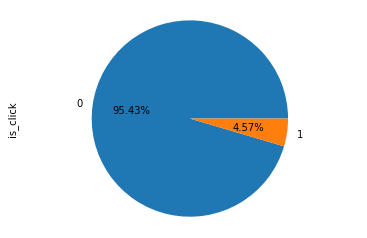

In [16]:
# Pie Plot to Visualise the Target Variable
label.value_counts().plot.pie(autopct='%1.2f%%')
plt.axis('equal')
plt.show()

- In the train dataset only 4.57% of the impressions were clicked

In [0]:
log_final = pd.merge(left= log, right= item, how= 'left', on= 'item_id')

In [22]:
log_final.head(3)

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0


In [33]:
nb_view_hist = log_final.groupby('user_id').count()[['session_id']]
nb_view_hist.columns = ['nb_view_hist']
train_df = pd.merge(train, nb_view_hist, how= 'left', on= 'user_id')
del nb_view_hist
gc.collect()

86

In [37]:
min_server_time = log_final.groupby('user_id').min()[['server_time']]
min_server_time.columns = ['min_server_time']
train_df = pd.merge(train_df, min_server_time, how= 'left', on= 'user_id')
del min_server_time
gc.collect()

154

In [38]:
max_server_time = log_final.groupby('user_id').max()[['server_time']]
max_server_time.columns = ['max_server_time']
train_df = pd.merge(train_df, max_server_time, how= 'left', on= 'user_id')
del max_server_time
gc.collect()

161

In [40]:
avg_item_price = log_final.groupby('user_id').mean()[['item_price']]
avg_item_price.columns = ['avg_item_price']
train_df = pd.merge(train_df, avg_item_price, how= 'left', on= 'user_id')
del avg_item_price
gc.collect()

160

In [41]:
train_df.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,nb_view_hist,min_server_time,max_server_time,avg_item_price
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2018-10-19 18:11:00,2018-10-19 18:11:00,2350.000000
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,12,2018-10-21 06:13:00,2018-12-10 20:03:00,4452.833333
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2,2018-10-23 12:59:00,2018-11-23 12:00:00,1598.500000
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,18,2018-11-11 21:18:00,2018-11-23 16:39:00,9963.388889
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,46,2018-10-18 12:02:00,2018-12-11 22:56:00,8618.934783
